In [1]:
#### Import dependencies
import face_functions as ff

import os, sys
import cv2
from PIL import Image
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import scipy
from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
%matplotlib inline

In [2]:
def get_faces_labels_pca(resized_images_path='Resized_Faces'):
    file_path = os.listdir(resized_images_path)
    faces = []
    face_labels = []
    current_id=0
    label_ids={}
    for file in file_path:
        if file.endswith("png") or file.endswith("jpg"):
            path=os.path.join(resized_images_path, file)
            label=os.path.basename(path).split(".")[1]
            #print(label,path)
            if not label in label_ids:
                #label_ids[label] = os.path.basename(path).split(".")[2]
                label_ids[label]=current_id
                current_id+=1

            id_=label_ids[label]
            pil_image=Image.open(path)#grayscale
            
            #reshape 2D array into 1D array
            image_array=np.array(pil_image,'uint8')
            image_1d = image_array.reshape(-1)
                           
            #print(image_array)
            faces.append(image_1d)
            face_labels.append(id_)
            faces_array = np.array(faces)
            labels_array = np.array(face_labels)
    return faces_array, labels_array, label_ids

In [3]:
face1d, labels, label_dict = ff.get_faces_labels_pca()
print(face1d.shape)
print(face1d.shape[0])
print(labels)
print(label_dict)

(50, 10000)
50
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7
 7 7 7 8 8 8 8 8 9 9 9 9 9]
{'bryan_lee': 0, 'bryan_lim': 1, 'edmund': 2, 'malvern': 3, 'peter': 4, 'terren': 5, 'wangjue': 6, 'yicheng': 7, 'yirong': 8, 'ziying': 9}


# Test

In [4]:
def illumination_normalize(array1d):
    image_bgr=[]
    image_ycrcb=[]
    image_gray=[]
    for i in array1d:
        image_reshape = i.reshape(100,100)
        bgr_image = cv2.cvtColor(image_reshape, cv2.COLOR_GRAY2BGR) # Convert gray to bgr
        ycrcb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2YCrCb) # Convert bgr to ycrcb
        # separate channels
        y, cr, cb = cv2.split(ycrcb_image)

        # get background which paper says (gaussian blur using standard deviation 5 pixel for 300x300 size image)
        # account for size of input vs 300
        sigma = int(5 * 100 / 100)
        #print('sigma: ',sigma)
        gaussian = cv2.GaussianBlur(y, (0, 0), sigma, sigma)

        # subtract background from Y channel
        y = (y - gaussian + 100)

        # merge channels back
        ycrcb = cv2.merge([y, cr, cb])

        #convert to BGR
        output_bgr = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
        
        #convert to grayscale
        output_gray = cv2.cvtColor(output_bgr, cv2.COLOR_BGR2GRAY) # 2D
        output_gray1d = output_gray.reshape(-1) # 1D
        
        image_gray.append(output_gray1d)
        image_gray_array = np.array(image_gray)
        image_bgr.append(bgr_image)
        image_bgr_array = np.array(image_bgr)
        image_ycrcb.append(ycrcb_image)
        image_ycrcb_array = np.array(image_ycrcb)

    return image_gray_array, image_bgr_array, image_ycrcb_array

In [5]:
test1, test2, test3 = illumination_normalize(face1d)

print(test1.shape)
print(test2.shape)
print(test3.shape)

(50, 10000)
(50, 100, 100, 3)
(50, 100, 100, 3)


In [46]:
print(face1d[0])
print(test1[0].reshape(-1))
print(a[0] is test1[0].reshape(-1))

[196 109  84 ...  43  56  94]
[169  83  60 ... 249   4  41]
False


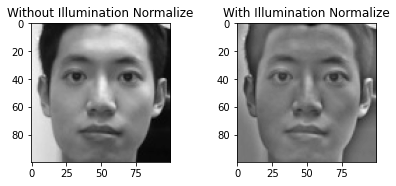

In [61]:
fig, ax = plt.subplots(1,2)
ax[0].set_title("Without Illumination Normalize")
ax[0].imshow(face1d[30].reshape(100,100), cmap='gray')
ax[1].set_title("With Illumination Normalize")
ax[1].imshow(test1[30].reshape(100,100), cmap='gray')
fig.tight_layout(pad=3.0)

In [106]:
def normalise_face(image, n=50, m=500):
    # Find average face based on face dataset, return shape (50, 10000)
    avg_face = np.mean(image, axis=0)
    print("avg face (1,10000): ", avg_face.shape)
    # Compute zero mean faces, return shape (50, 10000)
    zeromean_face = image - avg_face
    print("zero mean face (50,10000): ", zeromean_face.shape)
    # Compute covariance matrix, return shape (10000, 10000)
    covariance = np.dot(zeromean_face.T, zeromean_face) / n
    print("covariance matrix shape (10000, 10000): ", covariance.shape)
    total_features = image.shape[1] # 10000 features
    print("Calculaing top eigenvalues and corresponding eigenvectors...")
    # Compute eigenval and eigenvec, return shape (1, m) and (10000, m)
    eigenvalues, eigenvectors = linalg.eigh(covariance, eigvals=(total_features-m,total_features-1))
    print("eigenvalues shape (m,): ", eigenvalues.shape)
    print("eigenvectors shape (10000, m): ", eigenvectors.shape)
    print("Eigens Computation Done!")
    # Compute eigenfaces, return shape (m, 10000)
    eigenfaces = eigenvectors.T
    print("eigenface shape (m,10000)", eigenfaces.shape)
    # Project zero mean faces into eigen space for training, return shape (50, m)
    face_train = np.dot(zeromean_face, eigenvectors)
    print("face_train (50,m): ", face_train.shape)
    return avg_face, zeromean_face, eigenvalues, eigenvectors, eigenfaces, face_train, covariance

In [52]:
a, b, c, d, e, f, g = normalise_face1(face1d)

avg face (1,10000):  (10000,)
zero mean face (50,10000):  (50, 10000)
covariance matrix shape (10000, 10000):  (10000, 10000)
Calculaing top eigenvalues and corresponding eigenvectors...
eigenvalues shape (m,):  (10,)
eigenvectors shape (10000, m):  (10000, 10)
Eigens Computation Done!
eigenface shape (m,10000) (10, 10000)
face_train (50,10):  (50, 10)


In [107]:
t, u, v, w, x, y, z = normalise_face(test1)

avg face (1,10000):  (10000,)
zero mean face (50,10000):  (50, 10000)
covariance matrix shape (10000, 10000):  (10000, 10000)
Calculaing top eigenvalues and corresponding eigenvectors...
eigenvalues shape (m,):  (500,)
eigenvectors shape (10000, m):  (10000, 500)
Eigens Computation Done!
eigenface shape (m,10000) (500, 10000)
face_train (50,m):  (50, 500)


IndexError: index 20 is out of bounds for axis 0 with size 20

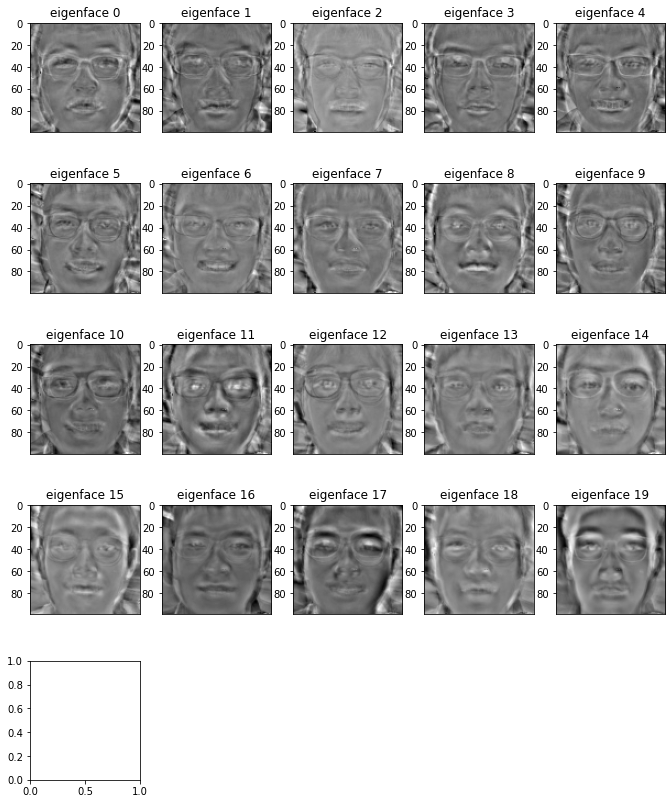

In [76]:
eigenface_titles = ["eigenface %d" % i for i in range(x.shape[0])]
ff.plot_gallery(x, eigenface_titles, 100, 100)
plt.show()

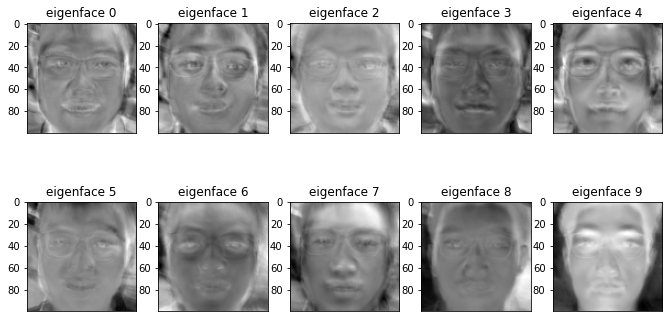

In [8]:
eigenface_titles = ["eigenface %d" % i for i in range(e.shape[0])]
plot_gallery(e, eigenface_titles, 100, 100)
plt.show()

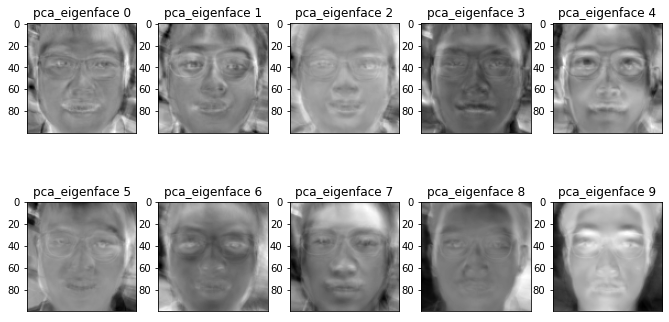

In [21]:
eigenface_titles = ["pca_eigenface %d" % i for i in range(pca.components_.shape[0])]
plot_gallery(e, eigenface_titles, 100, 100)
plt.show()

In [66]:
def normalise_test_face(image, avg_face, eigenvectors):
    zeromean_testface = image - avg_face
    face_test = np.dot(zeromean_testface, eigenvectors)
    return zeromean_testface, face_test

In [108]:
from sklearn.svm import SVC
import pickle
print("Fitting the classifier to the training set")
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
#clf = GridSearchCV(SVC(kernel='poly', class_weight='balanced', random_state=66), param_grid)
#clf = clf.fit(face_train, labels)
#print("Best estimator found by grid search:")
#print(clf.best_estimator_)
model = SVC(kernel='rbf', probability=True, random_state=66)
#svc = model.fit(face_train, labels)
svc = model.fit(y, labels)
# Save trained model
with open('svc_rbf_500.pickle', 'wb') as saved_model:
    pickle.dump(svc, saved_model, protocol=pickle.HIGHEST_PROTOCOL)
print("Model is saved!")

Fitting the classifier to the training set
Model is saved!


In [109]:
# Real Time Detection using SVM
def pca_face_recognition(avgface, eigenvectors):
    faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') # load classifier
    eye_glassesCascade = cv2.CascadeClassifier('haarcascade_eye_tree_eyeglasses.xml')
    
    # Load trained model
    with open('svc_rbf_500.pickle', 'rb') as saved_model:
        svc = pickle.load(saved_model)

    cap = cv2.VideoCapture(0)

    names = ['Bryan_Lee', 'Bryan_Lim', 'Edmund', 'Malvern', 'Peter', 'Ter_Ren', 
             'Wang_Jue', 'Yi_Cheng', 'Yi_Rong', 'Zi_Ying']
    cap.set(3,640) # set Width
    cap.set(4,480) # set Height
    while True:
        _, frame = cap.read()
        frame = cv2.flip(frame, 1)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # detect faces
        faces = faceCascade.detectMultiScale(
            gray,     
            scaleFactor=1.2,
            minNeighbors=5,     
            minSize=(5, 5)
        )
        for (x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
            roi_color = frame[y:y+h, x:x+w]
            roi_gray = gray[y:y+h, x:x+w]
    #        roi_gray = cv2.resize(roi_gray, (100,100))
            eyes = eye_glassesCascade.detectMultiScale(roi_gray, scaleFactor=1.2, minNeighbors=5, minSize=(5,5))
            for (ex, ey, ew, eh) in eyes:
                cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
    #         smile = smileCascade.detectMultiScale(roi_gray, scaleFactor=1.2, minNeighbors=25, minSize=(120,120))
    #         for (xx, yy, ww, hh) in smile:
    #             cv2.rectangle(roi_color, (xx, yy), (xx + ww, yy + hh), (0, 0, 255), 2)
            gray_face = cv2.resize((gray[y:y+h,x:x+w]),(100,100))
            gray_face_1d = gray_face.reshape(1,-1)
            illum_test_face, _, _ = illumination_normalize(gray_face_1d)
            normface_test, test_face = normalise_test_face(illum_test_face, avgface, eigenvectors)
            #plt.imshow(normface_test.reshape(100,100), cmap='gray')
            y_pred = svc.predict_proba(test_face)
            #top_prob = max(y_pred)
            top_prob_name = names[np.argmax(y_pred)]
            top_prob = y_pred[:,np.argmax(y_pred)]
            print(y_pred)
            #print(top_prob)
            
            #text = str(y_pred[0]) + ':' + names[int(y_pred[0])]
            text = str(top_prob_name) + "-Prob: " + str(top_prob)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(frame, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
            
        cv2.imshow('frame',frame)
        k = cv2.waitKey(1) & 0xff
        if k == 27: # press 'ESC' to quit
            break
    cap.release()
    cv2.destroyAllWindows()

In [40]:
pca_face_recognition(a,d)

In [110]:
pca_face_recognition(t,w)

[[0.04108192 0.20766731 0.0419647  0.03775013 0.02104595 0.04820611
  0.03362468 0.28470515 0.0696462  0.21430785]]
[[0.03894916 0.14584786 0.04310042 0.0384119  0.02775582 0.06415608
  0.05520997 0.20311879 0.0919308  0.2915192 ]]
[[0.04399259 0.18571706 0.044395   0.04138237 0.02231918 0.05382233
  0.03885914 0.22569427 0.06809949 0.27571856]]
[[0.04298086 0.19076984 0.04919096 0.04399076 0.02375741 0.05844159
  0.03973468 0.23162367 0.06517488 0.25433535]]
[[0.04059714 0.19988933 0.04887057 0.03836742 0.02627747 0.0656391
  0.05101948 0.24411654 0.07724443 0.20797851]]
[[0.04115852 0.129712   0.04588654 0.04137678 0.02812703 0.06646483
  0.05184879 0.17546127 0.10461029 0.31535395]]
[[0.05501031 0.17950274 0.0771178  0.04873784 0.03431182 0.10752108
  0.0723184  0.24548104 0.07671599 0.10328297]]
[[0.04881765 0.20044718 0.06216702 0.05121053 0.02523171 0.073345
  0.03874566 0.27614366 0.06829101 0.15560059]]
[[0.03835442 0.17632951 0.05660363 0.04820812 0.02536089 0.05682316
  0.059

[[0.03526638 0.25384132 0.03179532 0.02929293 0.01835426 0.03992194
  0.02268151 0.30522194 0.11659624 0.14702816]]
[[0.03536968 0.25985398 0.03086835 0.02944595 0.01878791 0.04099345
  0.02157674 0.31945645 0.1062204  0.13742708]]
[[0.03472382 0.24668748 0.03322198 0.02957529 0.02050481 0.04250622
  0.02472782 0.29593185 0.12344456 0.14867619]]
[[0.03529062 0.24336813 0.02978405 0.02810113 0.01970199 0.04168057
  0.02271948 0.32150962 0.10829882 0.14954558]]
[[0.04018648 0.25028321 0.03291016 0.03095667 0.01822182 0.03977434
  0.02247611 0.26209693 0.10115043 0.20194384]]
[[0.03957442 0.24285503 0.02994364 0.02962496 0.01867984 0.04306271
  0.02005644 0.29548414 0.08661898 0.19409984]]
[[0.04019109 0.24928023 0.0310353  0.03196741 0.01792902 0.0422618
  0.02002161 0.28899644 0.08393473 0.19438237]]
[[0.03574725 0.25733016 0.03777873 0.04447767 0.01967927 0.06338369
  0.0182349  0.30591329 0.07022885 0.14722619]]
[[0.03483391 0.27611631 0.03279883 0.03540985 0.01721393 0.04487263
  0.0

In [42]:
pca_face_recognition(a,pca.components_.T)

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.05960589 0.12610872 0.06512315 0.08398761]]
[[0.10987761 0.08551686 0.12460955 0.19429395 0.05892671 0.09194995
  0.

# PCA + SVM

In [49]:
from sklearn.decomposition import PCA as RandomizedPCA
n_components = 10
pca = RandomizedPCA(n_components=n_components, svd_solver='randomized', whiten=True, random_state=55).fit(face1d)

In [41]:
print(pca.components_.shape) # Top eigenface shape
print(pca.components_.T.shape)
print(pca.components_)

(10, 10000)
(10000, 10)
[[ 0.01043073  0.01105696  0.01265145 ...  0.02283592  0.02277198
   0.02251579]
 [-0.0002063   0.00164319  0.00297139 ... -0.01359182 -0.01476396
  -0.01562049]
 [ 0.01130062  0.00911906  0.01055729 ...  0.00620782  0.00633874
   0.00624983]
 ...
 [ 0.0046097   0.00376527 -0.00546399 ... -0.00105234 -0.00293327
  -0.00289562]
 [ 0.02286427  0.02423647  0.02109398 ... -0.00496088 -0.00080397
   0.00099233]
 [-0.01133989 -0.00250146  0.00739421 ... -0.01807409 -0.01866843
  -0.0194984 ]]


In [47]:
print(d.T.shape)
print(d.T)

(10, 10000)
[[ 0.01274844  0.00386087 -0.00637662 ...  0.0183435   0.01855814
   0.01949274]
 [ 0.02242022  0.02379904  0.02071939 ... -0.00510651 -0.00089012
   0.00094429]
 [-0.00464774 -0.00380054  0.00544025 ...  0.00105058  0.00293983
   0.00289516]
 ...
 [ 0.01130057  0.00911901  0.01055725 ...  0.00620782  0.00633874
   0.00624984]
 [ 0.0002063  -0.00164319 -0.00297139 ...  0.01359182  0.01476396
   0.01562049]
 [-0.01043073 -0.01105696 -0.01265145 ... -0.02283592 -0.02277198
  -0.02251579]]


In [24]:
print(pca.explained_variance_.shape)
print(pca.explained_variance_)

(10,)
[5458150.85556456 3707143.02987384 1960273.44390318 1531975.38312878
  801866.37499399  597109.64730615  443070.03439426  357883.82169436
  263989.93828974  219427.66682081]


In [54]:
print(c.shape)
print(c)

(10,)
[ 215319.25412956  258748.33242862  350726.71851825  434208.88409884
  585167.46745036  785829.04831207 1501335.87546955 1921067.97502823
 3633000.16927637 5348987.83845327]


In [25]:
pca.explained_variance_ratio_

array([0.30926408, 0.21005029, 0.11107098, 0.0868032 , 0.04543452,
       0.03383281, 0.02510477, 0.02027804, 0.01495792, 0.01243298])

In [26]:
pca.singular_values_

array([16353.88002655, 13477.75977171,  9800.68358592,  8664.10951993,
        6268.28942972,  5409.10091586,  4659.4454268 ,  4187.63743214,
        3596.59658235,  3279.01748611])

In [27]:
pca.n_samples_

50

In [28]:
pca.n_components_

10

In [29]:
pca.n_features_

10000

In [30]:
# Project zero mean face into eigen space
pca_face_train = pca.transform(face1d)
print(pca_face_train.shape)
print(pca_face_train)

(50, 10)
[[-2.94866712e-01 -1.19655496e+00  1.27035310e+00 -2.83430227e-01
  -1.34672490e+00  2.80231091e-02  1.85453716e+00  2.07874344e-01
   1.89465844e-01 -1.38827716e+00]
 [-2.65819172e-01 -1.18802080e+00  1.29759365e+00 -1.48314228e-01
  -1.32988058e+00 -1.12653028e-01  2.14576416e+00  3.01487199e-02
   2.89389904e-01 -1.60723124e+00]
 [-1.66633985e-01 -1.20508284e+00  1.40763207e+00 -1.20100488e-01
  -1.27850524e+00 -2.13840099e-01  2.33179131e+00 -2.10768005e-01
   2.01407823e-01 -1.55117035e+00]
 [-3.74634354e-01 -1.14022761e+00  1.49496966e+00 -4.91334654e-01
  -1.94153038e+00 -5.27128055e-01  7.07575971e-01 -2.34118656e-01
  -1.16608593e+00  1.40637397e+00]
 [-3.04146969e-01 -1.15938565e+00  1.37357125e+00 -5.19128067e-01
  -2.07581515e+00 -7.95226041e-01  4.30940975e-01 -5.44863449e-01
  -1.68402653e+00  2.72508835e+00]
 [-3.90983999e-01 -6.13438488e-01 -7.93167151e-01 -7.18192935e-01
  -2.75412725e-01  5.07842715e-01 -1.01605922e+00  2.95758723e+00
  -3.84142389e-01 -2.643

In [38]:
print(f.shape)
print(f)
# Projection result is different when pca package is not used.

(50, 10)
[[ 6.59523711e+02  9.48971141e+01 -1.24704629e+02  1.23426113e+03
   2.16281193e+01  1.20594614e+03  3.50809796e+02  1.77861815e+03
   2.30384004e+03  6.88887834e+02]
 [ 7.56500055e+02  1.46315243e+02 -1.81567506e+01  1.42822525e+03
  -8.70608344e+01  1.19086398e+03  1.83572905e+02  1.81675772e+03
   2.28740842e+03  6.21024979e+02]
 [ 7.21344409e+02  1.00991376e+02  1.26246737e+02  1.55218533e+03
  -1.65219688e+02  1.14486151e+03  1.48652012e+02  1.97082243e+03
   2.32025958e+03  3.89301741e+02]
 [-6.53333923e+02 -5.98179869e+02  1.39838007e+02  4.70883719e+02
  -4.07334081e+02  1.73858241e+03  6.08139273e+02  2.09310338e+03
   2.19538768e+03  8.75246472e+02]
 [-1.28655771e+03 -8.61377299e+02  3.26371163e+02  2.87092097e+02
  -6.14469096e+02  1.85883710e+03  6.42540799e+02  1.92313420e+03
   2.23227446e+03  7.10569004e+02]
 [ 1.28087286e+02 -1.94359396e+02 -1.76956757e+03 -6.76437924e+02
   3.92402994e+02  2.46627212e+02  8.88928849e+02 -1.11051149e+03
   1.18111094e+03  9.134

In [36]:
from sklearn.svm import SVC
import pickle
print("Fitting the classifier to the training set")
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
#clf = GridSearchCV(SVC(kernel='poly', class_weight='balanced', random_state=66), param_grid)
#clf = clf.fit(face_train, labels)
#print("Best estimator found by grid search:")
#print(clf.best_estimator_)
model_pca = SVC(kernel='rbf', probability=True, random_state=66)
#svc = model.fit(face_train, labels)
svc = model_pca.fit(pca_face_train, labels)
# Save trained model
with open('svc_rbf_10_pca.pickle', 'wb') as saved_model:
    pickle.dump(svc, saved_model, protocol=pickle.HIGHEST_PROTOCOL)
print("Model is saved!")

Fitting the classifier to the training set
Model is saved!
